In [1]:
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression, get_full_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib as mpl
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()

torch.manual_seed(42)


# Helper functions

In [2]:

def log_prior(model, theta_mu=None, sigma=None):
    # params -
    # TODO de-spaghettize this once the priors are coded properly
    prior_dict = {'SE': {'raw_lengthscale' : {"mean": -0.21221139138922668 , "std":1.8895426067756804}},
                  'MAT52': {'raw_lengthscale' :{"mean": 0.7993038925994188, "std":2.145122566357853 } },
                  'MAT32': {'raw_lengthscale' :{"mean": 1.5711054238673443, "std":2.4453761235991216 } },
                  'RQ': {'raw_lengthscale' :{"mean": -0.049841950913676276, "std":1.9426354614713097 },
                          'raw_alpha' :{"mean": 1.882148553921053, "std":3.096431944989054 } },
                  'PER':{'raw_lengthscale':{"mean": 0.7778461197268618, "std":2.288946656544974 },
                          'raw_period_length':{"mean": 0.6485334993738499, "std":0.9930632050553377 } },
                  'LIN':{'raw_variance' :{"mean": -0.8017903983055685, "std":0.9966569921354465 } },
                  'c':{'raw_outputscale':{"mean": -1.6253091096349706, "std":2.2570021716661923 } },
                  'noise': {'raw_noise':{"mean": -3.51640656386717, "std":3.5831320474767407 }}}
    #prior_dict = {"SE": {"raw_lengthscale": {"mean": 0.891, "std": 2.195}},
    #              "MAT": {"raw_lengthscale": {"mean": 1.631, "std": 2.554}},
    #              "PER": {"raw_lengthscale": {"mean": 0.338, "std": 2.636},
    #                      "raw_period_length": {"mean": 0.284, "std": 0.902}},
    #              "LIN": {"raw_variance": {"mean": -1.463, "std": 1.633}},
    #              "c": {"raw_outputscale": {"mean": -2.163, "std": 2.448}},
    #              "noise": {"raw_noise": {"mean": -1.792, "std": 3.266}}}

    variances_list = list()
    debug_param_name_list = list()
    theta_mu = list()
    params = list()
    covar_string = gsr(model.covar_module)
    covar_string = covar_string.replace("(", "")
    covar_string = covar_string.replace(")", "")
    covar_string = covar_string.replace(" ", "")
    covar_string = covar_string.replace("PER", "PER+PER")
    covar_string_list = [s.split("*") for s in covar_string.split("+")]
    covar_string_list.insert(0, ["LIKELIHOOD"])
    covar_string_list = list(chain.from_iterable(covar_string_list))
    both_PER_params = False
    for (param_name, param), cov_str in zip(model.named_parameters(), covar_string_list):
        params.append(param.item())
        debug_param_name_list.append(param_name)
        # First param is (always?) noise and is always with the likelihood
        if "likelihood" in param_name:
            theta_mu.append(prior_dict["noise"]["raw_noise"]["mean"])
            variances_list.append(prior_dict["noise"]["raw_noise"]["std"])
            continue
        else:
            if (cov_str == "PER" or cov_str == "RQ") and not both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = True
            elif (cov_str == "PER" or cov_str == "RQ") and both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = False
            else:
                try:
                    theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                    variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                except Exception as E:
                    import pdb
                    pdb.set_trace()
                    prev_cov = cov_str
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(0).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    sigma = sigma@sigma
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    # for convention reasons I'm diving by the number of datapoints
    return prior.log_prob(torch.Tensor(params)).item() / len(*model.train_inputs)



def random_reinit(model):
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        covar_text = gsr(model.covar_module)
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value



def optimize_hyperparameters(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    line_search = kwargs.get("line_search", False)
    BFGS_iter = kwargs.get("BFGS_iter", 50)
    train_iterations = kwargs.get("train_iterations", 0)
    X = kwargs.get("X", model.train_inputs)
    Y = kwargs.get("Y", model.train_targets)
    with_BFGS = kwargs.get("with_BFGS", False)
    history_size = kwargs.get("history_size", 100)
    MAP = kwargs.get("MAP", True)
    prior = kwargs.get("prior", False)
    granso = kwargs.get("granso", True)

    if log_likelihood:
        likelihood_log = list()
        best_likelihood_log = likelihood_log
    if log_param_path:
        param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}
        for param_name in model.named_parameters():
            param_log_dict[param_name[0]].append(param_name[1].item())
        best_param_log_dict = param_log_dict


    mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = -mll(model(X), Y)
    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()
    

    for restart in range(random_restarts):
        try:
            #optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
            #mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)
            ## Train the ADAM part
            #for _ in range(train_iterations):
            #    optimizer.zero_grad()
            #    output = model(X)
            #    loss = -mll(output, Y)
            #    if MAP:
            #        log_p = log_prior(model)
            #        loss -= log_p
            #    loss.backward()
            #    optimizer.step()
            #    if log_param_path:
            #        for param_name in model.named_parameters():
            #            param_log_dict[param_name[0]].append(param_name[1].item())
            #    if log_likelihood:
            #        likelihood_log.append(loss.item())
            ## Train the L-BFGS part
            #if with_BFGS:
            #    optimizer = torch.optim.LBFGS(model.parameters(), history_size=history_size, max_iter=BFGS_iter, line_search_fn=None if not line_search else "strong_wolfe")
            #    def closure():
            #        optimizer.zero_grad()
            #        output = model(X)
            #        loss = -mll(output, Y)
            #        if MAP:
            #            log_p = log_prior(model)
            #            loss -= log_p
            #        loss.backward()
            #        return loss
            #    loss = optimizer.step(closure)
            if granso:
                print("I USE GRANSO")
                # Set up the PyGRANSO optimizer
                opts = pygransoStruct()
                opts.torch_device = torch.device('cpu')
                nvar = getNvarTorch(model.parameters())
                opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
                opts.opt_tol = 1e-10
                opts.limited_mem_size = 100
                opts.globalAD = True
                opts.quadprog_info_msg = False
                opts.print_level = 0
                opts.halt_on_linesearch_bracket = False

                # Define the objective function
                def objective_function(model):
                    output = model(X)
                    loss = -mll(output, Y)
                    if MAP:
                        log_p = log_prior(model)
                        loss -= log_p
                    print(loss)
                    return [loss, None, None]

                print(f"pre training: {list(model.named_parameters())} w. loss: {objective_function(model)[0]}")
                # Train the model using PyGRANSO
                soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
                print(f"post training: {list(model.named_parameters())} w. loss: {soln.final.f}")
                print(f"post training: {list(model.named_parameters())} w. loss: {soln.best.f}")

            # I can't log using the closure since it's called too often when using line search
            if log_param_path:
                if with_BFGS:
                    for param_num, param_name in enumerate(model.named_parameters()):
                        if len(optimizer.state_dict()["state"]) > 1:
                            pdb.set_trace()
                        for step in optimizer.state_dict()["state"][0]["old_stps"]:
                            param_log_dict[param_name[0]].append(param_log_dict[param_name[0]][-1] + step[param_num])
            if log_likelihood:
                likelihood_log.append(loss.item())
            #if loss < best_loss:
            #    best_loss = loss
            #    best_model_state_dict = model.state_dict()
            #    best_likelihood_state_dict = likelihood.state_dict()
            #    if any([log_likelihood, log_param_path]):
            #        if log_likelihood:
            #            best_likelihood_log = likelihood_log 
            #            likelihood_log = list()
            #        if log_param_path:
            #            best_param_log_dict = param_log_dict
            #            param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}
        # Training blew up
        except Exception as E:
            random_reinit(model)
            pass 
        # print output if enabled
        if options["training"]["print_optimizing_output"]:
            print(f"HYPERPARAMETER OPTIMIZATION: Random Restart {restart}: loss: {loss}, optimal loss: {best_loss}")
        random_reinit(model)
    #model.load_state_dict(best_model_state_dict)
    #likelihood.load_state_dict(best_likelihood_state_dict)

    # Zero gradients from previous iteration
    #optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    if MAP:
        log_p = log_prior(model)
        loss -= log_p
    if any([log_likelihood, log_param_path]):
        logables = dict()
        if log_likelihood:
            logables["log_likelihood"] = best_likelihood_log
        if log_param_path:
            logables["log_param_path"] = best_param_log_dict
        return loss, logables, model, likelihood
    else:
        return loss, model, likelihood




# Define the training loop
def optimize_hyperparameters2(model, likelihood, train_x, train_y):
    # Set up the likelihood and model
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    #model = GPModel(train_x, train_y, likelihood)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = 1e-10
    opts.limited_mem_size = 100
    opts.globalAD = True
    opts.quadprog_info_msg = False
    opts.print_level = 0
    opts.halt_on_linesearch_bracket = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        loss = -mll(output, train_y)
        log_p = log_prior(model)
        loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = 5
    best_f = np.inf
    for restart in range(random_restarts):
        # Train the model using PyGRANSO
        soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)

    loss = -mll(model(train_x), train_y)
    log_p = log_prior(model)
    loss -= log_p

    print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    #torch.autograd.grad(mll, params_list, retain_graph=True, create_graph=True, allow_unused=True)
    # Return the trained model
    return loss, model, likelihood


In [3]:
def get_std_points(mu, K):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = 50
    unit_x = torch.cat([torch.linspace(-1, 1, precision), torch.linspace(-1, 1, precision)])
    unit_y = torch.cat([torch.sqrt(1 - torch.linspace(-1, 1, precision)**2), -torch.sqrt(1 - torch.linspace(-1, 1, precision)**2)])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + 2*res[0])
        new_unit_y.append(mu[1] + 2*res[1])
    return new_unit_x, new_unit_y

# Pre-diddling

In [4]:
# Globals
figure_path = "linear_figures"

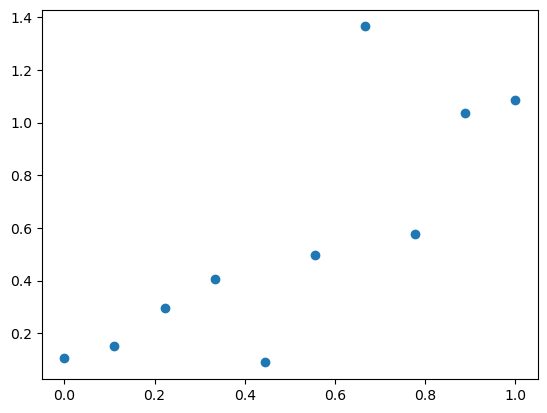

In [5]:
torch.manual_seed(42)
END = 1
COUNT = 10
train_x = torch.linspace(0, END, COUNT)
train_y = torch.linspace(0, END, COUNT)
train_y += torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1))
plt.plot(train_x, train_y, "o")

# Model definition

In [6]:
# Simplest GP possible. SE with constant sigma_f 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-30))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [7]:
print(torch.linalg.eigh(model(train_x).covariance_matrix)[0].flip(0))
print(model(train_x).covariance_matrix)

tensor([ 8.3621e+00,  1.5041e+00,  1.2708e-01,  6.5276e-03,  2.2986e-04,
         5.6375e-06,  2.2122e-07,  3.9967e-08, -2.4226e-08, -8.4223e-08],
       grad_fn=<FlipBackward0>)
tensor([[1.0000, 0.9872, 0.9499, 0.8908, 0.8142, 0.7253, 0.6297, 0.5328, 0.4394,
         0.3532],
        [0.9872, 1.0000, 0.9872, 0.9499, 0.8908, 0.8142, 0.7253, 0.6297, 0.5328,
         0.4394],
        [0.9499, 0.9872, 1.0000, 0.9872, 0.9499, 0.8908, 0.8142, 0.7253, 0.6297,
         0.5328],
        [0.8908, 0.9499, 0.9872, 1.0000, 0.9872, 0.9499, 0.8908, 0.8142, 0.7253,
         0.6297],
        [0.8142, 0.8908, 0.9499, 0.9872, 1.0000, 0.9872, 0.9499, 0.8908, 0.8142,
         0.7253],
        [0.7253, 0.8142, 0.8908, 0.9499, 0.9872, 1.0000, 0.9872, 0.9499, 0.8908,
         0.8142],
        [0.6297, 0.7253, 0.8142, 0.8908, 0.9499, 0.9872, 1.0000, 0.9872, 0.9499,
         0.8908],
        [0.5328, 0.6297, 0.7253, 0.8142, 0.8908, 0.9499, 0.9872, 1.0000, 0.9872,
         0.9499],
        [0.4394, 0.5328, 0.62

# Training

In [8]:
num_train_iter = 0
use_MAP = True 
use_LBFGS = False
LBFGS_iter = 50
# Train the MAP for 100 Iterations of ADAM and then 50 more of L-BFGS
loss, model, likelihood = optimize_hyperparameters2(model, likelihood, train_x, train_y)
#loss,  model, likelihood = optimize_hyperparameters(model, likelihood, 
#                                                                 line_search=False, 
#                                                                 X=train_x, 
#                                                                 Y=train_y, 
#                                                                 train_iterations=0, 
#                                                                 #BFGS_iter=LBFGS_iter, 
#                                                                 #history_size=2*LBFGS_iter, 
#                                                                 #with_BFGS=use_LBFGS, 
#                                                                 #MAP=use_MAP, 
#                                                                 log_param_path=False, 
#                                                                 random_restarts=1, 
#                                                                 log_likelihood=False)


/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1675740247391/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.4198], dtype=torch.float64, requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.5204]], dtype=torch.float64, requires_grad=True))] w. loss: 0.9174853492359207
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.4198], dtype=torch.float64, requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.5204]], dtype=torch.float64, requires_grad=True))] w. loss: 0.9174853492359207
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.4198], dtype=torch.float64, requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.5204]], dtype=torch.float64, requires_grad=True))] w. loss: 0.9174853492359207
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.4198], dtype=torch.float64, requires_gr

In [9]:
loss

tensor(0.9175, dtype=torch.float64, grad_fn=<SubBackward0>)

In [10]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-2.4198], dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_lengthscale',
  Parameter containing:
  tensor([[0.5204]], dtype=torch.float64, requires_grad=True))]

In [11]:
training_log

NameError: name 'training_log' is not defined

In [ ]:
print(torch.linalg.eigh(model(train_x).covariance_matrix)[0].flip(0))
print(model(train_x).covariance_matrix)

In [ ]:
print(f"{'MAP' if use_MAP else 'likelihood'}:{loss}")
print(list(model.named_parameters()))

In [ ]:
model.likelihood.noise

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
observed_pred.confidence_region()

In [ ]:
#plt.plot(training_log["log_param_path"]['likelihood.noise_covar.raw_noise'])
#plt.plot(training_log["log_likelihood"])
param_keys = list(training_log["log_param_path"].keys())
filtered = False 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(training_log["log_param_path"][param_keys[0]], training_log["log_param_path"][param_keys[1]], training_log["log_likelihood"]):
    if llik > -5000:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
else:
    for i in range(len(training_log["log_param_path"][param_keys[0]])-1):
        n, l = training_log["log_param_path"][param_keys[0]][i], training_log["log_param_path"][param_keys[1]][i]
        n2, l2 = training_log["log_param_path"][param_keys[0]][i+1], training_log["log_param_path"][param_keys[1]][i+1]
        plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(training_log["log_param_path"][param_keys[0]])), head_length = 0.47, head_width = 0.55, length_includes_head = True)
    plt.scatter(training_log["log_param_path"][param_keys[0]], training_log["log_param_path"][param_keys[1]], c=-torch.Tensor(training_log["log_likelihood"]), s=3)
plt.title("Log MAP (larger = better)" if use_MAP else "Log Likelihood (larger = better)")
plt.colorbar()

plt.plot(training_log["log_param_path"][param_keys[0]][-1], training_log["log_param_path"][param_keys[1]][-1], "ro") 


In [ ]:
with torch.no_grad():
    observed_pred_prior = likelihood(model(model.train_inputs[0]))

like_cov_chol = torch.linalg.cholesky(observed_pred_prior.covariance_matrix)
like_dist = torch.distributions.multivariate_normal.MultivariateNormal(observed_pred_prior.mean, scale_tril=like_cov_chol)
print(like_dist.log_prob(model.train_targets))
print(-training_log["log_likelihood"][-1]*COUNT)
print(-loss*COUNT)

In [ ]:
torch.linalg.eigh(observed_pred_prior.covariance_matrix)

# Laplace

In [ ]:
#training_log["training_log"][:-50]
len(training_log["log_likelihood"])

In [ ]:
#print(f"L-BFGS iterations: {len(training_log['log_likelihood']) - num_train_iter}")
model.train()
likelihood.train()

lap, lap_log = metrics.calculate_laplace(model, -loss, with_prior=True, param_punish_term=-1.0)
print(lap)
print(lap_log)

# Draw the distribution defined by the mean (found parametrization) and covariance matrix (Hessian)
# (4.133) in Bishop, 2006: f(z) ~ f(z_0)exp(-0.5 (z-z_0)^T H (z-z_0)) with z the parameters, and H the Hessian
# We just leave out the f(z_0)

scaling_factor = lap_log["neg MLL"]
mu = [training_log["log_param_path"][param_keys[0]][-1], training_log["log_param_path"][param_keys[1]][-1]]
K = lap_log["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
K = lap_log["original symmetrized Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
plt.scatter(new_unit_x, new_unit_y, color="black", s=3)



In [ ]:
torch.linalg.eigh(torch.tensor([[0.0453, 0.0083],
        [0.0083, 0.0205]]))

# MCMC

In [ ]:
from metrics import calculate_mc_STAN
# Perform MCMC
MCMC_approx, MC_log = calculate_mc_STAN(
    model, likelihood, 1000, log_param_path=True, log_full_likelihood=True)
print(MCMC_approx)

In [ ]:
# w. 0 ADAM (MAP)
#[('likelihood.noise_covar.raw_noise', Parameter containing:
#tensor([-11.8925], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
#tensor([[1.7432]], requires_grad=True))]
# w. 50 ADAM
# [('likelihood.noise_covar.raw_noise', Parameter containing:
# tensor([-11.6812], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
# tensor([[1.5973]], requires_grad=True))]
# w. 100 ADAM
# [('likelihood.noise_covar.raw_noise', Parameter containing:
# tensor([-10.8088], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
# tensor([[1.8571]], requires_grad=True))]

#max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
#for i, param in enumerate(MC_log['param draws dict']):
#    print(f"{lap_log['parameter list'][i]}:{MC_log['param draws dict'][param][max_index]}")

In [ ]:


for param_name in MC_log['param draws dict']:
    plt.hist(MC_log['param draws dict'][param_name])
print(MC_log["Parameter prior"])
plt.savefig(f"{figure_path}/MCMC_param_distribution_{COUNT}_datapoints.png")

In [ ]:
plt.plot(MC_log['manual lp list'])
plt.title("Log Likelihood")

In [ ]:
print(MC_log["Parameter statistics"])

mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
K = lap_log["corrected Hessian"]
print(f"{[training_log['training_log'][param_key][-1] for param_key in param_keys]}")
print(f"{K.inverse().diag()}")

In [ ]:

    max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
    print(f"{max(MC_log['manual lp list'])} : {MC_log['param draws dict']['theta.1'][max_index]} {MC_log['param draws dict']['theta.2'][max_index]}")

In [ ]:
#
#scaling_factor = lap_log["neg MLL"]
#mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
##plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

filtered = False 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], MC_log['manual lp list']):
    if llik > -100:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
    max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
    print(f"{max(MC_log['manual lp list'])} : {MC_log['param draws dict']['theta.1'][max_index]} {MC_log['param draws dict']['theta.2'][max_index]}")
    plt.plot(MC_log['param draws dict']["theta.1"][max_index], MC_log['param draws dict']["theta.2"][max_index], "ro")
else:
    for i in range(len(MC_log['param draws dict']["theta.1"])-1):
        n, l = MC_log['param draws dict']["theta.1"][i], MC_log['param draws dict']["theta.2"][i]
        n2, l2 = MC_log['param draws dict']["theta.1"][i+1], MC_log['param draws dict']["theta.2"][i+1]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(MC_log['param draws dict']["theta.1"])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], c=torch.Tensor(MC_log['manual lp list']), s=3)
    max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
    plt.plot(MC_log['param draws dict']["theta.1"][max_index], MC_log['param draws dict']["theta.2"][max_index], "ro")

plt.colorbar() 

mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
K = lap_log["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)

K = lap_log["original symmetrized Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="turquoise", s=3)
plt.title("Log Likelihood")


In [ ]:
# Contour plot of the likelihood surface according to the explored samples
# loop to filter draws below -5000
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()
for n, l, llik in zip(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], MC_log['manual lp list']):
    if llik > -5000:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)
plt.scatter(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], c=range(len(MC_log['param draws dict']["theta.2"])), cmap="Greens", s=2)
plt.colorbar() 
## Drawing the parameter Prior
new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].numpy().T[0][:2], MC_log["Parameter prior"]["var"].inverse()[:2, :2])
# Draw one standard deviation around the center of the distribution
plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)
#plt.scatter(filtered_noise, filtered_length, c=filtered_loglike)



plt.title("Log Likelihood")

In [ ]:
def f4(x):
    return x + torch.log(-torch.expm1(-x))
f4(torch.tensor(1e-4))
torch.nn.functional.softplus(torch.tensor(-9.2102))